## End to End Lead Scoring with Python and DataRobot

**Author**: Thodoris Petropoulos

### Scope
The scope of this notebook is to provide an end to end demonstration of how Python can be used jointly with DataRobot to produce a lead scoring model.

### Background
Lead scoring is the process of building a list of prospects ranked against their perceived value to a given purpose. In Ecommerce for instance, one might be interested in creating a list of customers who are highly likely to purchase a product after receiving a Direct Message. For call centers, one might want to direct customers who could be persuaded not to unsubscribe to more experienced customer representatives. In the financial market, one might create a list of potentially good borrowers. In the online game business, lead scoring may help a business focus their efforts on attracting users who are likely to subscribe to a paid service.

### Requirements

- Python version 3.7.3
-  DataRobot API version 2.19.0. 
Small adjustments might be needed depending on the Python version and DataRobot API version you are using.

Full documentation of the Python package can be found here: https://datarobot-public-api-client.readthedocs-hosted.com

#### Import Libraries
To start with, lets import the libraries that will be used in this tutorial

In [1]:
import datarobot as dr
import pandas as pd
import time

#### Import Dataset
The dataset we will be using comes from a company that sells online courses to industry professionals.

Each row represents a person who landed on the website, and each column represents some information about this prospect. For example, “lead origin,” “lead source,” and “total time spent on the website.”

This dataset can be found and downloaded through Kaggle: https://www.kaggle.com/ashydv/leads-dataset.

The target column is “Converted,” which indicates whether or not this prospect bought a course.


In [3]:
df = pd.read_csv('data/leads.csv')
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


#### Connect to DataRobot
Connect to DataRobot using your api token and your endpoint. Change input below accordingly.

In [5]:
token = 'YOUR_TOKEN'
endpoint = 'YOUR_DR_URL/api/v2'

dr.Client(token=token, 
          endpoint= endpoint)

#### Create a Project
Now that we are connected to DataRobot, we can create a project using the method <code>dr.Project.create</code>:

In [7]:
#First create the project
project = dr.Project.create(project_name='LeadScoringUseCase',
                        sourcedata= df)

#### Create a custom feature list
Lets have a look at what the features are in the Informative Featurelist. This is the default featurelist that DataRobot will use to initiate the project's Autopilot.

In [18]:
for featurelist in project.get_featurelists():
    if featurelist.name == 'Informative Features':
        print(featurelist.features)

['Lead Origin', 'Lead Source', 'Do Not Email', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Tags', 'Lead Quality', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'A free copy of Mastering The Interview', 'Last Notable Activity']


I see that the <code>Tags</code> column will be used.

DataRobot, during the second phase of exploratory data analysis (which starts with autopilot), will automatically detect [target leakage](https://community.datarobot.com/t5/ai-ml-general-blog/what-is-target-leakage-and-how-do-i-avoid-it/ba-p/1973) based on the feature importance score (not to be confused with [feature impact](https://app.datarobot.com/docs/modeling/investigate/understand/feature-impact.html)) of each feature.

We will remove the <code>Tags</code> column as we suspect it might introduce target leakage even though its feature importance score falls right below the default threshold that DataRobot has.

In [20]:
ml_features = ['Lead Origin', 'Lead Source', 'Do Not Email', 'Converted', 
               'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
               'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 
               'What is your current occupation', 'What matters most to you in choosing a course', 
               'Search', 'Lead Quality', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 
               'Asymmetrique Profile Index', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 
               'A free copy of Mastering The Interview', 'Last Notable Activity']

featurelist = project.create_featurelist('InformativeFeaturesNoTagsColumn', 
                                         features=ml_features)

#### Starting Project
Now that my custom feature list is created, I can use the <code>set_target</code> method to indicate the project's target and tell DataRobot to use the custom feature list that I created in the previous step.

The <code>set_target</code> method will also initiate DataRobot's autopilot.

In [23]:
project.set_target(
    target='Converted',
    featurelist_id = featurelist.id,
    worker_count = '-1',
)
project.wait_for_autopilot() #Wait for autopilot to complete

In progress: 20, queued: 14 (waited: 0s)
In progress: 20, queued: 14 (waited: 1s)
In progress: 20, queued: 14 (waited: 2s)
In progress: 20, queued: 14 (waited: 4s)
In progress: 20, queued: 14 (waited: 5s)
In progress: 20, queued: 14 (waited: 8s)
In progress: 20, queued: 14 (waited: 12s)
In progress: 20, queued: 14 (waited: 20s)
In progress: 19, queued: 13 (waited: 34s)
In progress: 20, queued: 10 (waited: 55s)
In progress: 20, queued: 1 (waited: 76s)
In progress: 16, queued: 0 (waited: 97s)
In progress: 16, queued: 0 (waited: 117s)
In progress: 11, queued: 0 (waited: 138s)
In progress: 6, queued: 0 (waited: 159s)
In progress: 3, queued: 0 (waited: 180s)
In progress: 3, queued: 0 (waited: 201s)
In progress: 0, queued: 0 (waited: 221s)
In progress: 16, queued: 0 (waited: 242s)
In progress: 16, queued: 0 (waited: 263s)
In progress: 14, queued: 0 (waited: 283s)
In progress: 8, queued: 0 (waited: 304s)
In progress: 2, queued: 0 (waited: 325s)
In progress: 2, queued: 0 (waited: 345s)
In prog

#### Inspecting top models

The autopilot is done...What to do next? Obviously, we would want to see the top 5 models and their respective LogLoss score (or any metric but this is the default currently chosen).

In [50]:
models = project.get_models(order_by='metric')

In [51]:
for model in models[-5:]:
    print(model)
    print(model.metrics['LogLoss']['validation'])

Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping')
0.29686
Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping')
0.29656
Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping')
0.2963
Model('AVG Blender')
0.29582
Model('GLM Blender')
0.2956


The best model based on the validation logloss score is a GLM Blender model. Next, lets see what features have the most impact on this model.

#### Plotting Feature Impact for best model

In [8]:
import datarobot as dr
token = 'YOUR_TOKEN'
endpoint = 'YOUR_ENDPOINT'

dr.Client(token=token, 
          endpoint= endpoint)

models = project.get_models(order_by='metric')

In [9]:
#Pick best model
best_model = models[-1]

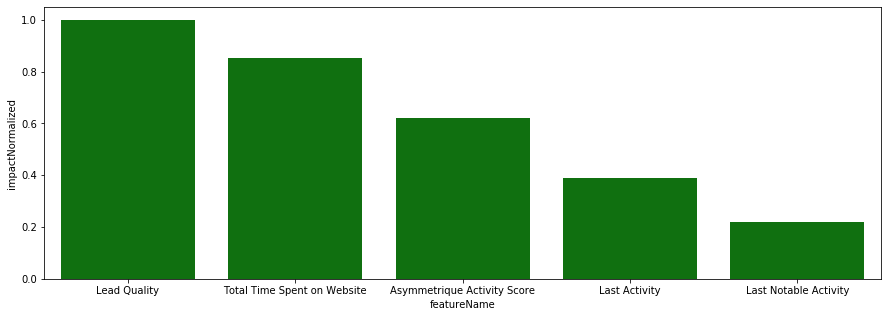

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

#Get Feature Impact
feature_impact = best_model.get_or_request_feature_impact()

#Save feature impact in pandas dataframe
fi_df = pd.DataFrame(feature_impact)

fig, ax = plt.subplots(figsize = (15,5))

#Plot feature impact
sns.barplot(x='featureName', y='impactNormalized', data=fi_df[0:5], color='g')

Lead quality and total time spent on website are the two top predictors of why someone converted or not. It makes sense for these features to be at the top. We could try to make some decisions based on this information, but it is important to know *how* these features are impacting the likelihood to convert.

To start down on that path, lets see how the different values of "Lead Quality" and "total time spent on website" affect the target outcome:

In [152]:
feature_effects = best_model.request_feature_effect()
feature_effects.wait_for_completion() #Wait till feature effects computes

def generate_dataframe_from_feature_effects(feature_effects, column):
    temp_pd = list(feature_effects.get_result())
    for item in temp_pd:
        if item['feature_name'] == column:
            partial_dependence_data = item['partial_dependence']['data']
            partial_dependence_data_df = pd.DataFrame(partial_dependence_data) #Save results into a pandas dataframe
            partial_dependence_data_df.columns = ['target_probability','value']
            try:
                partial_dependence_data_df['value'] = round(partial_dependence_data_df['value'].astype('float'),1)
            except:
                pass
    return partial_dependence_data_df

Plot for <code>Lead Quality</code>

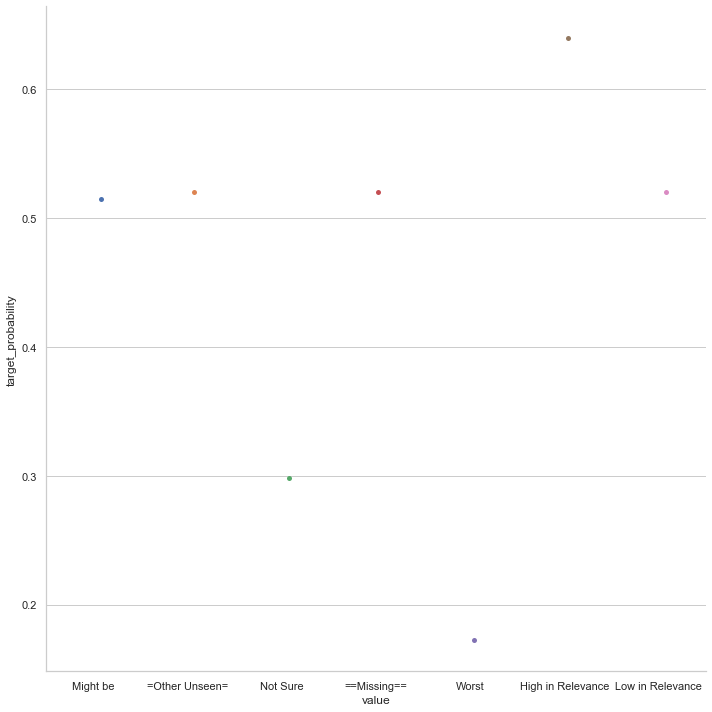

In [155]:
sns.catplot(x="value", y="target_probability", height=10, data=generate_dataframe_from_feature_effects(feature_effects,'Lead Quality'))

Plot for <code>Total Time Spent on Website</code>

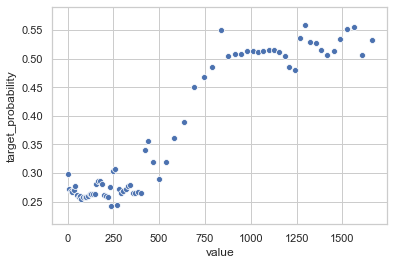

In [154]:
g = sns.scatterplot(x="value", y="target_probability",data=generate_dataframe_from_feature_effects(feature_effects,'Total Time Spent on Website'))                                                                    


For starters, it seems like that leads that are highest in relevance have the highest probability of converting. Maybe that means that the company should invest more money to getting more leads from relevant websites. 

Furthermore, the more time someone spents on a website, the higher the probability that that person will convert. This does have some diminishing effects though. After the 800 seconds mark, it seems like the probability to convert does not increase further. This info, could be used to design the website in a way that keeps prospects occupied for at least 800 seconds. The more time they invest in the website, the higher the probability they will buy in the end.

# Plotting the ROC Curve
I will use the <code>get_roc_curve</code> method to download the accuracy metrics for each different prediction threshold and plot the ROC curve using Matplotlib.

(0, 1)

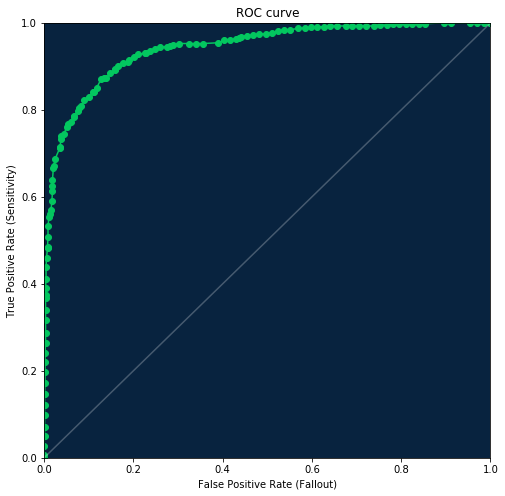

In [63]:
roc = best_model.get_roc_curve('validation')

#Save the result into a pandas dataframe
roc_df = pd.DataFrame(roc.roc_points)

dr_roc_green = '#03c75f'
white = '#ffffff'
dr_purple = '#65147D'
dr_dense_green = '#018f4f'
dr_dark_blue = '#08233F'

fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(1, 1, 1, facecolor=dr_dark_blue)

plt.scatter(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot(roc_df.false_positive_rate, roc_df.true_positive_rate, color=dr_roc_green)
plt.plot([0, 1], [0, 1], color=white, alpha=0.25)
plt.title('ROC curve')
plt.xlabel('False Positive Rate (Fallout)')
plt.xlim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.ylim([0, 1])

#### Finding best prediction threshold to maximize f1 score
We can use the <code>get_roc_curve</code> command to get the ROC curve data points.

In [ ]:
roc = best_model.get_roc_curve('validation')

#Save the result into a pandas dataframe
roc_df = pd.DataFrame(roc.roc_points)

I can also see the raw table of the results and find out the prediction threshold that maximises the f1 score (or any KPI I want really)

In [84]:
roc_df.head()

,accuracy,f1_score,false_negative_score,false_positive_rate,false_positive_score,fraction_predicted_as_negative,fraction_predicted_as_positive,lift_negative,lift_positive,matthews_correlation_coefficient,negative_predictive_value,positive_predictive_value,threshold,true_negative_rate,true_negative_score,true_positive_rate,true_positive_score
0,0.614604,0.000000,570,0.0000,0,1.000000,0.000000,1.000000,0.000000,0.000000,0.614604,0.000000,1.000000,1.0000,909,0.000000,0
1,0.617309,0.013937,566,0.0000,0,0.997295,0.002705,1.002712,2.594737,0.065763,0.616271,1.000000,0.997007,1.0000,909,0.007018,4
2,0.624746,0.051282,555,0.0000,0,0.989858,0.010142,1.010246,2.594737,0.127826,0.620902,1.000000,0.995319,1.0000,909,0.026316,15
3,0.632860,0.093489,542,0.0011,1,0.980392,0.019608,1.018878,2.505263,0.168571,0.626207,0.965517,0.993442,0.9989,908,0.049123,28
4,0.641650,0.133987,529,0.0011,1,0.971602,0.028398,1.028095,2.532957,0.207530,0.631872,0.976190,0.991625,0.9989,908,0.071930,41


In [85]:
#Use loc pandas dataframe method to find max f1 score and specified threshold value
optimal_threshold = roc_df.loc[roc_df['f1_score'] == roc_df['f1_score'].max()]['threshold'].values[0]
print(optimal_threshold)

0.33128651162303163


So, to optimise on f1 score, all I need to do is pick a prediction threshold of 0.33. Lets keep this information for later.

#### Prework to Deployment
To deploy the model, we first need to ensure that the model is trained on all of the data. To do that, we first need to unlock the project holdout and then retrain the model on 100% of the data.

In [91]:
#Unlocking Holdout
project.unlock_holdout()

Project(LeadScoringUseCase)

In [ ]:
#Retraining the model
retrained_model_number = best_model.train(100)

#Sleep while waiting for the modeling jobs to complete
while len(project.get_model_jobs()) != 0:
    time.sleep(5)

#Overwriting best_model with newly trained best model
for model in project.get_models():
    if model.model_number == retrained_model_number:
        best_model = model
        
print(best_model, best_model.sample_pct)

#### Deploy the model

Once we are certain on the model we want to use, we can deploy it easily with the following code: 

In [ ]:
prediction_server = dr.PredictionServer.list()[0]

deployment = dr.Deployment.create_from_learning_model(
    best_model.id, label='Lead Scoring Deployment', description='Score prospects against their propensity to convert',
    default_prediction_server_id=prediction_server.id)
deployment